 #### @Author: Mingcheng Wang (wmingch@uw.edu)

### Import packages

In [1]:
import pprint
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt 
import gc

from sklearn.model_selection import GroupShuffleSplit

import xgboost as xgb

pd.set_option('display.max_columns', None)

### data processing

In [2]:
#%%time
dir_file = '/glade/scratch/wmingch/ML_project/Expedia_rank/'
train = pd.read_csv(dir_file + 'train.csv')
test = pd.read_csv(dir_file + 'test.csv')

In [3]:
train.head()

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,position,price_usd,promotion_flag,srch_destination_id,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,srch_query_affinity_score,orig_destination_distance,random_bool,comp1_rate,comp1_inv,comp1_rate_percent_diff,comp2_rate,comp2_inv,comp2_rate_percent_diff,comp3_rate,comp3_inv,comp3_rate_percent_diff,comp4_rate,comp4_inv,comp4_rate_percent_diff,comp5_rate,comp5_inv,comp5_rate_percent_diff,comp6_rate,comp6_inv,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool
0,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,893,3,3.5,1,2.83,0.0438,4.95,27,104.77,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
1,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,10404,4,4.0,1,2.20,0.0149,5.03,26,170.74,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
2,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,21315,3,4.5,1,2.20,0.0245,4.92,21,179.80,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
3,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,27348,2,4.0,1,2.83,0.0125,4.39,34,602.77,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,-1.0,0.0,5.0,-1.0,0.0,5.0,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,0.0,5.0,0,NaN,0
4,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,29604,4,3.5,1,2.64,0.1241,4.93,4,143.58,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0


In [4]:
# create  target booking for 1, and click for 0.2
def get_target(booking, click):
    return booking + 0.2 * click

In [5]:
train['target'] = list(map(get_target, train['booking_bool'], train['click_bool']))

In [6]:
# features not available in test data 
columns_drop = ['position','click_bool','booking_bool','gross_bookings_usd']
train.drop(columns_drop, axis=1, inplace=True)

In [7]:
def process_date_time(df):
    df['dayofyear'] = df.date_time.dt.dayofyear
    df['dayofweek'] = df.date_time.dt.dayofweek
    df['month'] = df.date_time.dt.month
    df['hour'] = df.date_time.dt.hour
    
    return df

In [8]:
train['date_time'] = pd.to_datetime(train['date_time'])
process_date_time(train)
train.drop(['date_time'],axis=1, inplace=True)

In [9]:
test['date_time'] = pd.to_datetime(test['date_time'])
process_date_time(test)
test.drop(['date_time'],axis=1, inplace=True)

### split train data 

In [10]:
gss = GroupShuffleSplit(test_size=0.4, n_splits=1, random_state=17).split(train, groups=train['srch_id'])
X_train_inds, X_valid_test_inds = next(gss)

In [11]:
valid_test = train.iloc[X_valid_test_inds]
gss = GroupShuffleSplit(test_size=0.5, n_splits=1, random_state=16).split(valid_test, groups=valid_test['srch_id'])
X_valid_inds, X_test_inds = next(gss)

In [12]:
print(len(X_train_inds))
print(len(X_valid_inds))
print(len(X_test_inds))

5950110
1987657
1979763


In [13]:
%%time

#whole train data, used for final model training after model parameter tuning
X_train_whole = train.loc[:, ~train.columns.isin(['srch_id','target'])]
y_train_whole = train.loc[:, 'target']

print(X_train_whole.shape)
print(y_train_whole.shape)

# xgboost needs the number of samples for each query
train_whole_groups = train.groupby('srch_id').size().to_numpy()
print(train_whole_groups)

(9917530, 52)
(9917530,)
[28 32  5 ... 31 21  7]
CPU times: user 1.27 s, sys: 4.05 s, total: 5.32 s
Wall time: 6.03 s


In [14]:
%%time
train_data = train.iloc[X_train_inds]

X_train = train_data.loc[:, ~train_data.columns.isin(['srch_id','target'])]
y_train = train_data.loc[:, 'target']
print(X_train.shape)
print(y_train.shape)

# xgboost needs the number of samples for each query
train_groups = train_data.groupby('srch_id').size().to_numpy()
print(train_groups)

(5950110, 52)
(5950110,)
[32  5 21 ... 32 31  7]
CPU times: user 2.23 s, sys: 11 s, total: 13.2 s
Wall time: 42.2 s


In [15]:
%%time
valid_data = train.iloc[X_valid_test_inds].iloc[X_valid_inds]

X_valid = valid_data.loc[:, ~valid_data.columns.isin(['srch_id','target'])]
y_valid = valid_data.loc[:, 'target']
print(X_valid.shape)
print(y_valid.shape)

# xgboost needs the number of samples for each query
valid_groups = valid_data.groupby('srch_id').size().to_numpy()
print(valid_groups)

(1987657, 52)
(1987657,)
[28 32 32 ... 32 32 34]
CPU times: user 1.63 s, sys: 3.27 s, total: 4.9 s
Wall time: 7.13 s


In [16]:
%%time
test_data = train.iloc[X_valid_test_inds].iloc[X_test_inds]

X_test = test_data.loc[:, ~test_data.columns.isin(['srch_id','target'])]
y_test = test_data.loc[:, 'target']
print(X_test.shape)
print(y_test.shape)

# xgboost needs the number of samples for each query
test_groups = test_data.groupby('srch_id').size().to_numpy()
print(test_groups)

(1979763, 52)
(1979763,)
[31 34 27 ... 19 32 21]
CPU times: user 1.62 s, sys: 5.77 s, total: 7.4 s
Wall time: 16.9 s


In [17]:
%%time
X_test_predicted = test.loc[:, ~test.columns.isin(['srch_id'])]
test_predicted_groups = test.groupby('srch_id').size().to_numpy()
print(test_predicted_groups)

[13 33 30 ... 17 27 31]
CPU times: user 1.18 s, sys: 6.35 s, total: 7.53 s
Wall time: 28.7 s


In [18]:
train_features = train.columns[~train.columns.isin(['srch_id','target'])]
print(train_features)

Index(['site_id', 'visitor_location_country_id', 'visitor_hist_starrating',
       'visitor_hist_adr_usd', 'prop_country_id', 'prop_id', 'prop_starrating',
       'prop_review_score', 'prop_brand_bool', 'prop_location_score1',
       'prop_location_score2', 'prop_log_historical_price', 'price_usd',
       'promotion_flag', 'srch_destination_id', 'srch_length_of_stay',
       'srch_booking_window', 'srch_adults_count', 'srch_children_count',
       'srch_room_count', 'srch_saturday_night_bool',
       'srch_query_affinity_score', 'orig_destination_distance', 'random_bool',
       'comp1_rate', 'comp1_inv', 'comp1_rate_percent_diff', 'comp2_rate',
       'comp2_inv', 'comp2_rate_percent_diff', 'comp3_rate', 'comp3_inv',
       'comp3_rate_percent_diff', 'comp4_rate', 'comp4_inv',
       'comp4_rate_percent_diff', 'comp5_rate', 'comp5_inv',
       'comp5_rate_percent_diff', 'comp6_rate', 'comp6_inv',
       'comp6_rate_percent_diff', 'comp7_rate', 'comp7_inv',
       'comp7_rate_percent_d

### xgboost 

In [19]:
dtrain_whole = xgb.DMatrix(X_train_whole, y_train_whole, feature_names=train_features)
dtrain_whole.set_group(train_whole_groups)

In [20]:
dtrain = xgb.DMatrix(X_train, y_train, feature_names=train_features)
dtrain.set_group(train_groups)

In [21]:
dvalid = xgb.DMatrix(X_valid, y_valid, feature_names=train_features)
dvalid.set_group(valid_groups)

In [22]:
dtest = xgb.DMatrix(X_test, y_test, feature_names=train_features)
dtest.set_group(test_groups)

In [23]:
dtest_predicted = xgb.DMatrix(X_test_predicted, feature_names=train_features)
dtest_predicted.set_group(test_predicted_groups)

- parameter tuning for xgboost model

In [24]:
# gridsearch_params = [
#     (subsample, colsample_bytree, eta, min_child_weight, max_depth, gamma)
#     for subsample in [0.6, 0.9]
#     for colsample_bytree in [0.6, 0.9]
#     for eta in [0.1, 0.3]
#     for min_child_weight in [1, 30]
#     for max_depth in [3, 6]
#     for gamma in [0.2, 0.3]
# ]

# print(len(gridsearch_params))

In [25]:
gridsearch_params = [
    (subsample, colsample_bytree, eta, min_child_weight, max_depth, gamma)
    for subsample in [1]
    for colsample_bytree in [1]
    for eta in [0.05, 0.3, 1]
    for min_child_weight in [30, 50, 100]
    for max_depth in [4, 6, 8]
    for gamma in [0.5, 1, 2]
]

print(len(gridsearch_params))

81


In [26]:
#%%time
dir_model_output = '/glade/scratch/wmingch/ML_project/Expedia_rank/parameter_tune/'
progress = []


# fixed parameters
param = {}
param['booster'] = 'gbtree'
param['eval_metric'] = 'ndcg@38'
param['objective'] ='rank:ndcg'

model_tune = 0
for subsample, colsample_bytree, eta, min_child_weight, max_depth, gamma in gridsearch_params:
    print('model tune {}: subsample: {}, colsample_bytree :{}, eta: {}, min_child_weight: {}, max_depth: {}, gamma: {}'.format(\
        model_tune,subsample, colsample_bytree, eta, min_child_weight, max_depth, gamma       
    ))
    param['subsample'] = subsample
    param['colsample_bytree'] = colsample_bytree #Denotes the fraction of columns to be randomly samples for each tree.
    param['eta'] = eta #learning rate, typical values 0.01-0.2, default=0.3
    param['min_child_weight'] = min_child_weight #Defines the minimum sum of weights of all observations required in a child, should tuned
    param['max_depth'] = max_depth # typical values 3-10
    param['gamma'] = gamma # Gamma specifies the minimum loss reduction required to make a split, should tuned
    progress_part = {}
    
    model_xgb = \
    xgb.train(params=param, 
              num_boost_round=10, 
              dtrain=dtrain, 
              evals=[(dtrain, 'train'), (dvalid, 'eval'), (dtest, 'test')],
              early_stopping_rounds=5,
              evals_result=progress_part)
    progress.append(progress_part)
    model_xgb.save_model(dir_model_output + 'LTR_expedia_' + str(model_tune).zfill(3) + '.json')
    model_tune += 1 
    gc.collect()

model tune 0: subsample: 1, colsample_bytree :1, eta: 0.05, min_child_weight: 30, max_depth: 4, gamma: 0.5
[0]	train-ndcg@38:0.61007	eval-ndcg@38:0.61104	test-ndcg@38:0.60976
[1]	train-ndcg@38:0.61720	eval-ndcg@38:0.61734	test-ndcg@38:0.61735
[2]	train-ndcg@38:0.61730	eval-ndcg@38:0.61739	test-ndcg@38:0.61743
[3]	train-ndcg@38:0.61724	eval-ndcg@38:0.61751	test-ndcg@38:0.61750
[4]	train-ndcg@38:0.61720	eval-ndcg@38:0.61749	test-ndcg@38:0.61747
[5]	train-ndcg@38:0.61721	eval-ndcg@38:0.61747	test-ndcg@38:0.61744
[6]	train-ndcg@38:0.61717	eval-ndcg@38:0.61747	test-ndcg@38:0.61741
[7]	train-ndcg@38:0.61726	eval-ndcg@38:0.61770	test-ndcg@38:0.61738
[8]	train-ndcg@38:0.61723	eval-ndcg@38:0.61767	test-ndcg@38:0.61738
model tune 1: subsample: 1, colsample_bytree :1, eta: 0.05, min_child_weight: 30, max_depth: 4, gamma: 1
[0]	train-ndcg@38:0.61007	eval-ndcg@38:0.61104	test-ndcg@38:0.60976
[1]	train-ndcg@38:0.61720	eval-ndcg@38:0.61734	test-ndcg@38:0.61735
[2]	train-ndcg@38:0.61730	eval-ndcg@38:0

In [27]:
progress

[{'train': OrderedDict([('ndcg@38',
                [0.610067,
                 0.617197,
                 0.617298,
                 0.617244,
                 0.617201,
                 0.617211,
                 0.617173,
                 0.617261,
                 0.617231])]),
  'eval': OrderedDict([('ndcg@38',
                [0.611045,
                 0.617342,
                 0.617394,
                 0.617512,
                 0.61749,
                 0.617468,
                 0.617475,
                 0.617702,
                 0.617671])]),
  'test': OrderedDict([('ndcg@38',
                [0.609759,
                 0.617349,
                 0.617428,
                 0.617502,
                 0.617469,
                 0.61744,
                 0.617406,
                 0.617378,
                 0.617385])])},
 {'train': OrderedDict([('ndcg@38',
                [0.610067,
                 0.617197,
                 0.617298,
                 0.617244,
          

In [28]:
def get_best_model(progress):
    best_eval_score = float('-inf')
    best_model_idx = None
    i = 0
    for pro in progress:
        orderdict = pro['eval']
        for k, v in orderdict.items():
            if v[-1] > best_eval_score:
                best_eval_score = v[-1]
                best_model_idx = i
        i += 1 
    return best_model_idx, best_eval_score
best_model_idx, best_eval_score = get_best_model(progress)
print(best_model_idx)
print('model tune {}: subsample: {}, colsample_bytree :{}, eta: {}, min_child_weight: {}, max_depth: {}, gamma: {}'.format(\
        best_model_idx, gridsearch_params[best_model_idx][0], gridsearch_params[best_model_idx][1], \
                    gridsearch_params[best_model_idx][2], gridsearch_params[best_model_idx][3], \
                    gridsearch_params[best_model_idx][4], gridsearch_params[best_model_idx][5]))      
print('Eval best score of ndcg@38: {}'.format(best_eval_score))

70
model tune 70: subsample: 1, colsample_bytree :1, eta: 1, min_child_weight: 50, max_depth: 8, gamma: 1
Eval best score of ndcg@38: 0.662681


In [29]:
best_param = gridsearch_params[best_model_idx]
print(best_param)

(1, 1, 1, 50, 8, 1)


- train model with the parameter found and with the whole train data set

In [30]:
#%%time
#train 100 boost tree
dir_model_output = '/glade/scratch/wmingch/ML_project/Expedia_rank/parameter_tune/'
progress = {}

# fixed parameters
param = {}
param['booster'] = 'gbtree'
param['eval_metric'] = 'ndcg@38'
param['objective'] ='rank:ndcg'

subsample, colsample_bytree, eta, min_child_weight, max_depth, gamma = best_param
print('best model finalized: subsample: {}, colsample_bytree :{}, eta: {}, min_child_weight: {}, max_depth: {}, gamma: {}'.format(\
       subsample, colsample_bytree, eta, min_child_weight, max_depth, gamma       
))
param['subsample'] = subsample
param['colsample_bytree'] = colsample_bytree
param['eta'] = eta
param['min_child_weight'] = min_child_weight 
param['max_depth'] = max_depth 
param['gamma'] = gamma 

model_xgb = \
xgb.train(params=param, 
          num_boost_round=100, 
          dtrain=dtrain_whole, 
          evals=[(dtrain_whole, 'train_whole')],
          evals_result=progress)
model_xgb.save_model(dir_model_output + 'LTR_expedia_' + 'best' + '.json')
gc.collect()

best model finalized: subsample: 1, colsample_bytree :1, eta: 1, min_child_weight: 50, max_depth: 8, gamma: 1
[0]	train_whole-ndcg@38:0.63631
[1]	train_whole-ndcg@38:0.64153
[2]	train_whole-ndcg@38:0.64979
[3]	train_whole-ndcg@38:0.65491
[4]	train_whole-ndcg@38:0.65839
[5]	train_whole-ndcg@38:0.66080
[6]	train_whole-ndcg@38:0.66300
[7]	train_whole-ndcg@38:0.66480
[8]	train_whole-ndcg@38:0.66614
[9]	train_whole-ndcg@38:0.66701
[10]	train_whole-ndcg@38:0.66786
[11]	train_whole-ndcg@38:0.66878
[12]	train_whole-ndcg@38:0.66955
[13]	train_whole-ndcg@38:0.67019
[14]	train_whole-ndcg@38:0.67059
[15]	train_whole-ndcg@38:0.67102
[16]	train_whole-ndcg@38:0.67143
[17]	train_whole-ndcg@38:0.67185
[18]	train_whole-ndcg@38:0.67234
[19]	train_whole-ndcg@38:0.67272
[20]	train_whole-ndcg@38:0.67320
[21]	train_whole-ndcg@38:0.67351
[22]	train_whole-ndcg@38:0.67382
[23]	train_whole-ndcg@38:0.67410
[24]	train_whole-ndcg@38:0.67438
[25]	train_whole-ndcg@38:0.67470
[26]	train_whole-ndcg@38:0.67499
[27]	trai

44

## post-analysis

- feature importance 

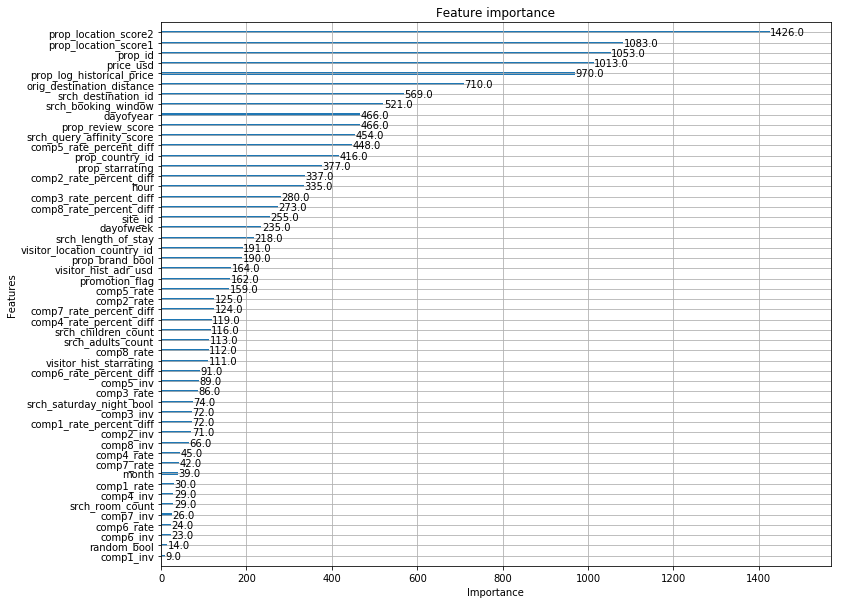

In [37]:
fig, ax = plt.subplots(figsize=(12, 10))
xgb.plot_importance(model_xgb, ax=ax, xlabel='Importance')

- plot tree

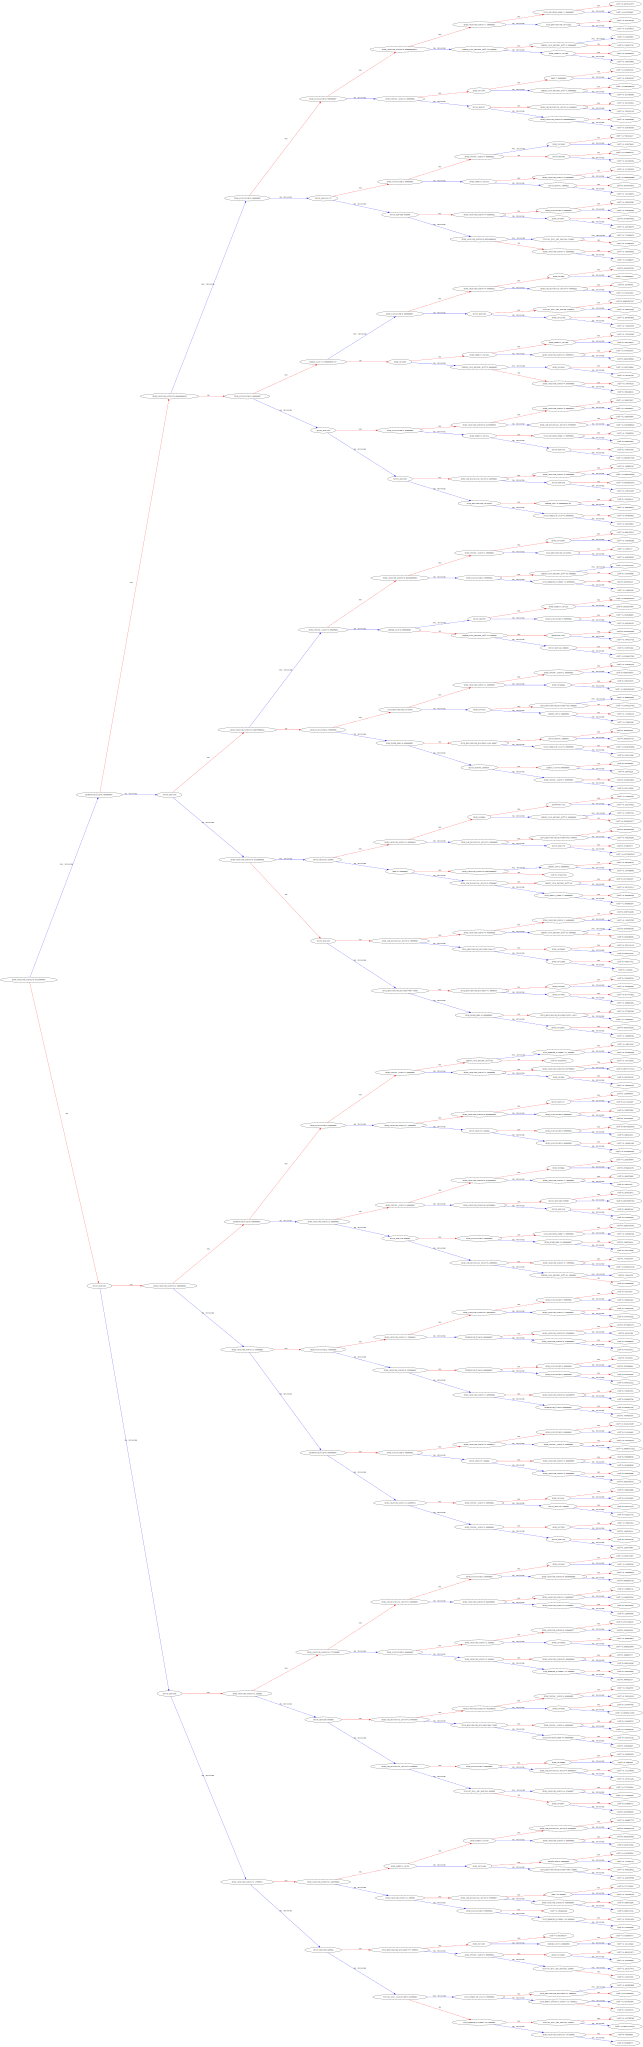

In [32]:
xgb.to_graphviz(model_xgb,  rankdir='LR')

#save tree as pdf file
# fig, ax = plt.subplots(figsize=(12, 12))
# image = xgb.to_graphviz(model_xgb_2,  rankdir='LR')
# image.graph_attr = {'dpi':'400'}
# image.render('xgb_graph.pdf')

### make prediction 

In [33]:
test_final_pred = model_xgb.predict(dtest_predicted)

In [34]:
test_submit_col = ['srch_id','prop_id']
test_submit = test[test_submit_col]
test_submit['predict'] = test_final_pred

/glade/work/wmingch/pylib_casper/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [35]:
test_submit.head(13)

,srch_id,prop_id,predict
0,2,3105,-2.316083
1,2,6399,0.157078
2,2,7374,0.845219
3,2,7771,-0.114497
4,2,12938,-0.655439
5,2,25579,1.656436
6,2,26540,0.547562
7,2,27090,-2.080020
8,2,30434,0.087890
9,2,37331,-1.176542


In [36]:
test_submit_rank = test_submit.sort_values(by=['srch_id', 'predict'], ascending=[True, False]).reset_index(drop=True)
test_submit_rank_final = test_submit_rank.drop(['predict'],axis=1)
test_submit_rank_final.columns =['SearchId','PropertyId']
test_submit_rank_final.to_csv(dir_model_output + 'kaggle_expedia_rank_submit.csv',index=False)